In [1]:
from tqdm import tqdm, trange
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import time
from datetime import timedelta

In [2]:
# Using the Stanford Dogs Dataset

In [3]:
def visualize_tensor(img, shape = None, unnorm = False):
    if unnorm:
        if len(img.shape) == 1:
            plt.imshow(invTrans(img.cpu().detach().reshape(shape)).permute(1,2,0).squeeze())
        elif len(img.shape) == 2:
            plt.imshow(invTrans(img[0].cpu().detach().reshape(shape)).permute(1,2,0).squeeze())
        elif len(img.shape) == 3:
            plt.imshow(invTrans(img.cpu().detach()).permute(1,2,0).squeeze())
        elif len(img.shape) == 4:
            plt.imshow(invTrans(img[0].cpu().detach()).permute(1,2,0).squeeze())
    else: 
        if len(img.shape) == 1:
            plt.imshow(img.cpu().detach().reshape(shape).permute(1,2,0).squeeze())
        elif len(img.shape) == 2:
            plt.imshow(img[0].cpu().detach().reshape(shape).permute(1,2,0).squeeze())
        elif len(img.shape) == 3:
            plt.imshow(img.cpu().detach().permute(1,2,0).squeeze())
        elif len(img.shape) == 4:
            plt.imshow(img[0].cpu().detach().permute(1,2,0).squeeze())
    plt.show()
    
def visualize_one(data_loader, shape = None):
    for i,(x,y) in enumerate(data_loader):
        visualize_tensor(x, shape)
        return
    
def print_update(epoch, iteration, loss, max_iters, start_time):
    t = time.perf_counter() - start_time
    dt = t / (iteration + 1)
    iters_left = max_iters - (iteration + 1)
    t_left = str(timedelta(dt*iters_left))
    minutesr, secondsr = divmod(iters_left * dt, 60)
    minutess, secondss = divmod(t, 60)
    times = [int(minutesr), int(secondsr), int(minutess), int(secondss)]
    for i in range(4):
        if times[i] < 10:
            times[i] = f'0{times[i]}'
    print('Epoch ', epoch, ': Iteration ', iteration+1, '/', max_iters, ' | Loss: ', loss, '  |  Time remaining: ', times[0], ':', times[1], '  |  Time spent: ', times[2], ':', times[3], end = '\r', sep = '')


In [4]:
def grayscale(x):
    x = torch.mean(x, dim = 1)
    return x

In [5]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True, loss = torch.nn.functional.l1_loss):
        super(VGGPerceptualLoss, self).__init__()
        self.loss = loss
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += self.loss(x, y)
        return loss

In [6]:
IMG_SHAPE = 64
BATCH_SIZE = 8
display_train_visuals = True
RGB64 = (3,IMG_SHAPE,IMG_SHAPE)
dog_transforms = [transforms.Resize((IMG_SHAPE,IMG_SHAPE)), transforms.ToTensor()]

def normalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1,3,1,1).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1,3,1,1).cuda()
    return (tensor - mean) / std

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ])])
dog_transforms = [transforms.Resize((IMG_SHAPE,IMG_SHAPE)), transforms.ToTensor()]

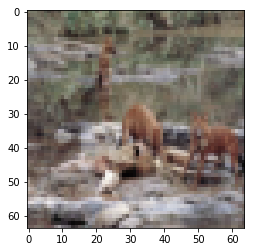

In [10]:
dog_imgs = ImageFolder('data/Images', transform = transforms.Compose(dog_transforms))
dog_loader = DataLoader(dog_imgs, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
visualize_one(dog_loader)

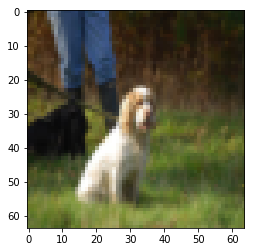

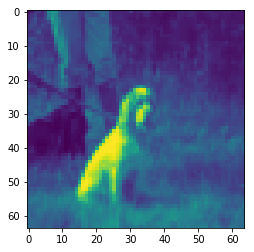

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


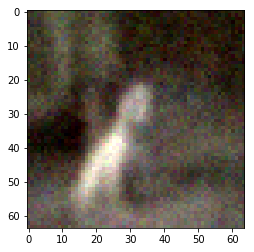

0.09150759391486644


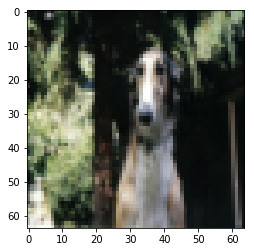

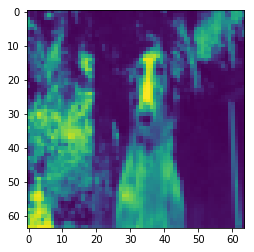

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


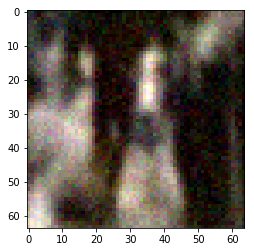

0.08175304904580116


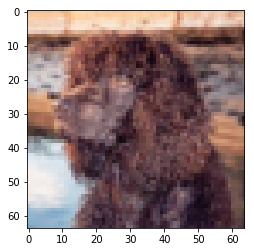

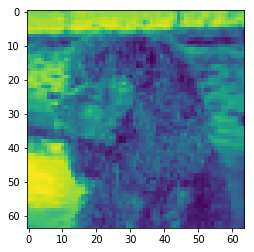

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


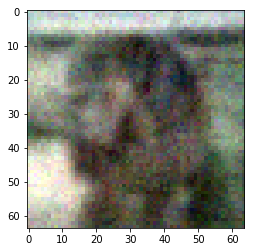

0.07143050990998745


In [11]:
linear_model = nn.Linear(IMG_SHAPE ** 2, IMG_SHAPE ** 2 * 3).cuda()
optimizer = optim.Adam(linear_model.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.999)
lossf = nn.L1Loss()

losses = []
for i in range(3):
    start_time = time.perf_counter()
    for j, (x,y) in enumerate(dog_loader):
        x_flat = x.reshape(x.shape[0], -1).cuda()
        x_flat_gray = grayscale(x).reshape(x.shape[0], -1).cuda()
        y_flat = linear_model(x_flat_gray)
        loss = lossf(y_flat, x_flat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         scheduler.step()
        losses.append(loss.item())

        if j % 20 == 0: print_update(i,j,np.round(loss.item(), decimals = 4),len(dog_loader), start_time)
        if j == len(dog_loader) - 1 and display_train_visuals:
            visualize_tensor(x_flat, RGB64)
            visualize_tensor(x_flat_gray, (1,64,64))
            visualize_tensor(y_flat, RGB64)
            
    print(np.mean(losses[-20:]))


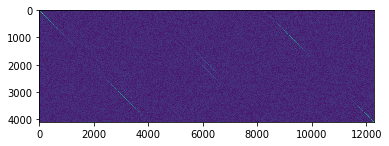

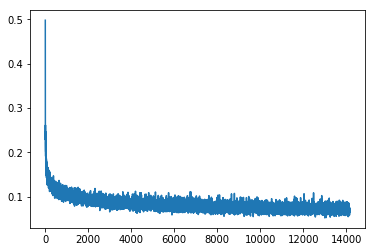

In [11]:
plt.imshow(linear_model.weight.data.detach().cpu().T)
plt.show()
plt.plot(losses)
plt.show()

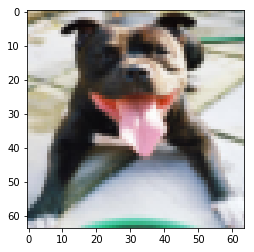

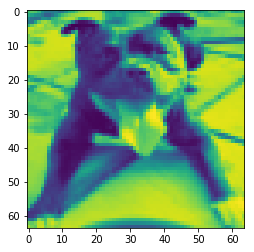

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


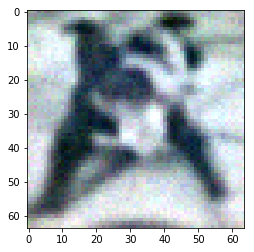

2.128286302089691


In [12]:
vggloss = VGGPerceptualLoss().cuda()
optimizer = optim.Adam(linear_model.parameters(), lr = 1e-5)
losses = []
for i in range(1):
    start_time = time.perf_counter()
    for j, (x,y) in enumerate(dog_loader):
        x_flat = x.reshape(x.shape[0], -1).cuda()
        x_flat_gray = grayscale(x).reshape(x.shape[0], -1).cuda()
        y_flat = linear_model(x_flat_gray)
        loss = vggloss(y_flat.reshape(y_flat.shape[0],3,IMG_SHAPE,IMG_SHAPE), x.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if j % 10 == 0: print_update(i,j,np.round(loss.item(), decimals = 4),len(dog_loader), start_time)
        if j == len(dog_loader) - 1 and display_train_visuals:
            visualize_tensor(x_flat, RGB64)
            visualize_tensor(x_flat_gray, (1,64,64))
            visualize_tensor(y_flat, RGB64)
            
    print(np.mean(losses[-20:]))

In [ ]:
plt.imshow(linear_model.weight.data.detach().cpu().T)
plt.show()
plt.plot(losses)
plt.show()